# Site selection for Starbucks

_Giulia Carella_

J.P. Morgan DeepFin Investor Workshop July 9 2020

## Context

Site selection refers to the process of deciding where to open a new or relocate an exiting store/facility by comparing the merits of potential locations. If some attribute of interest is known (e.g. the revenues of existing stores) statistical and machine learning methods can be used to help with the decision process. 

## What we will do

In this demo, we will look at where Starbucks should open new coffee shops in Long Island, NY. Specifically, we will build a model for the revenues of the existing stores as a funcion of sociodemographic data and use this model to predict the expected revenue in each block group.

We will:

- Read and upload to CARTO the revenue data 
- Geocode the store adresses (i.e. convert addresses to coordinates)
- Download for Long Island the US Census data by block group 
- Enrich each store location with the corresponding block group level Census data
- Build a predictive model for the store revenues
- Publish a visualization with the results
- Discuss how to improve the model results using spatial modelling

## Conclusions

- Using CARTO we were able to explore and visualize the Starbucks data and enrich them using demographics and socioeconomic data from CARTO Data Observatory
- We built a Generalized Linear model to predict the stores annual revenue from demographic and socioeconomic covariates, which were first transformed to impute missing data and reduce the model dimensionality.
- Predictive checks show that the model is accurate (pseudo R2 ~0.96) and we found that stores with larger annual revenues are located in richer areas and stores with a lower annual revenues are located in areas with a higher workforce density and with a higher concentration of mostly female seniors.
- By using a spatial model we were then able to show how to correct for spatial dependence in the residuals and improve the results.

### 0. Set up

#### Set up the virtual environment

First of all, install virtualenv inside your project folder to secure your project directory to avoid conflict with your other packages.

_pip install virtualenv_

After installing this run this command one by one inside your root project directory:

_virtualenv venv_
_source venv/bin/activate_

Now Your directory is secure and you can install your required packages inside.

_pip install - r requirements.txt_

#### Import the libraries

In [1]:
from requirements import *
from ppca import PPCA
from utils import *

sns.set_style("white")
np.random.seed(101)

#### Set CARTO credentials

Go to your CARTO dashboard anc click on __API KEY__ to get your key.

In [2]:
carto_username = 'XXXXXXXX'
carto_API = 'XXXXXXXX'

set_default_credentials(username=carto_username, api_key=carto_API)

## 1. Upload Starbucks store data to your CARTO account

First we upload the Starbucks data that are stored in your local in the starbucks_long_island.csv file. The data contains the addresses of Starbucks stores, their annual revenue ($) and some store characteristics (e.g. the number of open hours per week).

In [3]:
stores = pd.read_csv('./data/starbucks_long_island.csv')
stores.head(3)

,name,addresslines,hours_open_per_week,gc_status_rel,has_lu,has_cl,has_wa,has_vs,zipcode,storenumber,revenue
0,7000 Austin Street,"7000 Austin Street,Forest Hills, NY 11375",108.0,0.97,1,1,1,1,11375,7217-623,1.016898e+06
1,107-12 Continental Avenue,"107-12 Continental Avenue,Forest Hills, NY 11375",116.5,0.95,1,0,1,0,11375,7349-910,4.470646e+05
2,Stop & Shop-Forest Hills #539,"8989 Union Turnpike,Forest Hills, NY 11375",112.0,0.97,0,0,1,0,11375,73708-104729,7.028071e+05


Next, we will plot the distribution of the annual revenues by store.

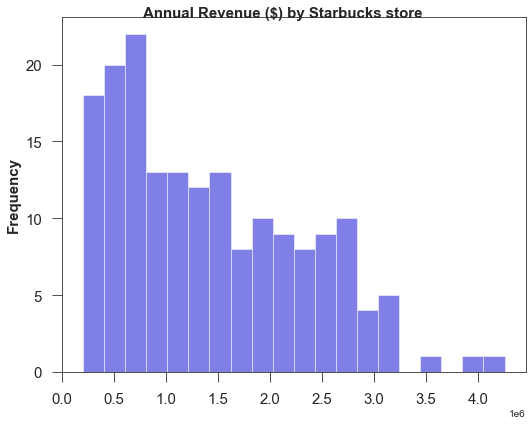

In [4]:
pandas_hist(stores, 'revenue',bins = 20, textsize = 15, title = 'Annual Revenue ($) by Starbucks store')

## 2. Geocode locations

Since we only know the addresses, we first need to geocode them to extract the corresponding geographical locations, which will be used to assign to each store the Census data of the corresponding block group.

In [5]:
geocoder = Geocoding()
stores = geocoder.geocode(stores, street='addresslines').data
stores.crs = {'init' :'epsg:4326'}

Success! Data geocoded correctly


### Upload data to CARTO

In [6]:
to_carto(stores,'starbucks_long_island_geocoded', if_exists = 'replace')

Success! Data uploaded to table "starbucks_long_island_geocoded" correctly


'starbucks_long_island_geocoded'

### Visualize the store locations

In [7]:
bk = [i*10**5 for i in [4, 7, 10, 13, 16]]
Map(
    Layer('starbucks_long_island_geocoded',
          style = size_bins_style('revenue', 
                                breaks = bk,
                                size_range = [1, 30],
                                color = '#00eaff',
                                stroke_color = '#006bff'),
          legends = size_bins_legend(title='Annual Revenue ($)',
                                   description='STARBUCKS', 
                                   footer =''),
    ),show_info = True,
    viewport={'zoom': 10, 'lat': 40.646891, 'lng': -73.869378},
    size=(920,300)
)

## 3. Download demographic and socioeconomic data by block group

Next, we will download from CARTO DATA Observatory (www.carto.com/data) the demographic and socioeconomic variables that we will use to build a model for the stores revenues. We will use data from the The American Community Survey (ACS), which is an ongoing survey by the U.S. Census Bureau. The ACS is available at the most granular resolution at the census block group level, with the most recent geography boundaries available for 2015. The data that we will use are from the survey run from 2013 to 2017.

### Upload Long Island geometry

As we are interested only in the data for the Long Island area, we first upload the geographical boundaries of this area from the manhattan_long_island.geojson file, which is stored locally.

In [8]:
aoi = gpd.read_file('./data/manhattan_long_island.geojson')

In [9]:
Map(
    Layer(aoi,
        style = basic_style(color = '#eaff00',
                            stroke_color = '#eaff00',
                            stroke_width = 2,
                            opacity = 0.2
        ),        
    ),show_info = True,
    viewport={'zoom': 7.5, 'lat': 40.845419, 'lng': -72.841376},
    size=(920,300)
)

### Look for the datasets of interest using the Data Discovery methods
More documentation here: https://carto.com/developers/cartoframes/guides/Data-discovery/

Let's start by exploring the Data Catalog to see what data categories CARTO can offer for data in the US.

In [10]:
Catalog().country('usa').categories

[<Category.get('covid19')>,
 <Category.get('demographics')>,
 <Category.get('environmental')>,
 <Category.get('financial')>,
 <Category.get('geosocial')>,
 <Category.get('housing')>,
 <Category.get('human_mobility')>,
 <Category.get('points_of_interest')>,
 <Category.get('road_traffic')>]

Then check the available providers and geometries and select the most recent ACS data at the block group level

In [11]:
Catalog().country('usa').category('demographics').datasets.to_dataframe().provider_id.unique()

array(['ags', 'mbi', 'usa_acs', 'experian', 'usa_bls'], dtype=object)

In [12]:
catalog_usa_demo = Catalog().country('usa').category('demographics').datasets.to_dataframe()
catalog_usa_demo_acs = catalog_usa_demo[catalog_usa_demo.provider_id == 'usa_acs']
catalog_usa_demo_acs.geography_name.unique()

array(['County - United States of America',
       'Core-based Statistical Area - United States of America',
       'Census Block Group - United States of America',
       'Census Place - United States of America',
       'School District (secondary) - United States of America',
       'School District (unified) - United States of America',
       'State - United States of America',
       'School District (elementary) - United States of America',
       'Congressional District - United States of America',
       'Public Use Microdata Area - United States of America',
       '5-digit Zip Code Tabulation Area - United States of America',
       'Census Tract - United States of America'], dtype=object)

In [13]:
catalog_usa_demo_acs_bk = catalog_usa_demo_acs[catalog_usa_demo_acs.geography_name == 'Census Block Group - United States of America']

In [14]:
catalog_usa_demo_acs_bk.id.to_list()

['carto-do-public-data.usa_acs.demographics_sociodemographics_usa_blockgroup_2015_5yrs_20132017',
 'carto-do-public-data.usa_acs.demographics_sociodemographics_usa_blockgroup_2015_5yrs_20082012',
 'carto-do-public-data.usa_acs.demographics_sociodemographics_usa_blockgroup_2015_5yrs_20102014',
 'carto-do-public-data.usa_acs.demographics_sociodemographics_usa_blockgroup_2015_5yrs_20122016',
 'carto-do-public-data.usa_acs.demographics_sociodemographics_usa_blockgroup_2015_5yrs_20072011',
 'carto-do-public-data.usa_acs.demographics_sociodemographics_usa_blockgroup_2015_5yrs_20112015',
 'carto-do-public-data.usa_acs.demographics_sociodemographics_usa_blockgroup_2015_5yrs_20062010',
 'carto-do-public-data.usa_acs.demographics_sociodemographics_usa_blockgroup_2015_5yrs_20092013']

And explore in greater detail the metadata

In [15]:
Dataset.get('carto-do-public-data.usa_acs.demographics_sociodemographics_usa_blockgroup_2015_5yrs_20132017').to_dict()

{'slug': 'acs_sociodemogr_b758e778',
 'name': 'Sociodemographics - United States of America (Census Block Group, 2017, 5yrs)',
 'description': 'The American Community Survey (ACS) is an ongoing survey that provides vital information on a yearly basis about the USA and its people. This dataset contains only a subset of the variables that have been deemed most relevant. More info: https://www.census.gov/programs-surveys/acs/about.html',
 'category_id': 'demographics',
 'country_id': 'usa',
 'data_source_id': 'sociodemographics',
 'provider_id': 'usa_acs',
 'geography_name': 'Census Block Group - United States of America',
 'geography_description': 'Shoreline clipped TIGER/Line boundaries. More info: https://carto.com/blog/tiger-shoreline-clip/',
 'temporal_aggregation': '5yrs',
 'time_coverage': '[2013-01-01, 2018-01-01)',
 'update_frequency': 'yearly',
 'is_public_data': True,
 'lang': 'eng',
 'version': '20132017',
 'category_name': 'Demographics',
 'provider_name': 'American Community

In [16]:
Geography.get('carto-do-public-data.carto.geography_usa_blockgroup_2015').to_dict()

{'slug': 'cdb_blockgroup_7753dd51',
 'name': 'Census Block Group - United States of America',
 'description': 'Shoreline clipped TIGER/Line boundaries. More info: https://carto.com/blog/tiger-shoreline-clip/',
 'country_id': 'usa',
 'provider_id': 'carto',
 'geom_type': 'MULTIPOLYGON',
 'update_frequency': None,
 'is_public_data': True,
 'lang': 'eng',
 'version': '2015',
 'provider_name': 'CARTO',
 'id': 'carto-do-public-data.carto.geography_usa_blockgroup_2015'}

Finally get the data and geometries

In [17]:
df_X = Dataset.get('acs_sociodemogr_b758e778')
q = "select * from $dataset$ where ST_Intersects(geom,st_geogfromtext('{}'))".format(aoi.geometry.astype(str)[0])
df_X = df_X.to_dataframe(sql_query=q)
df_X['geometry'] = df_X['geom'].apply(lambda x: str_to_geom(x))
df_X = GeoDataFrame(df_X,geometry = df_X.geometry)
df_X.crs = {'init' :'epsg:4326'}
df_X.head()

,geoid,do_date,total_pop,households,male_pop,female_pop,median_age,male_under_5,male_5_to_9,male_10_to_14,...,pop_in_labor_force,not_in_labor_force,armed_forces,civilian_labor_force,do_label,do_area,do_perimeter,do_num_vertices,geom,geometry
0,360470340002,2013-01-01,720.0,139.0,298.0,422.0,83.1,0.0,0.0,0.0,...,0.0,720.0,0.0,0.0,Block Group 2,47648.525,909.463,9,"POLYGON((-73.994726 40.57152, -73.993577 40.57...","POLYGON ((-73.99473 40.57152, -73.99358 40.571..."
1,360471058042,2013-01-01,784.0,586.0,316.0,468.0,80.0,0.0,0.0,0.0,...,14.0,770.0,0.0,14.0,Block Group 2,89274.575,1206.945,9,"POLYGON((-73.889591 40.651338, -73.889994 40.6...","POLYGON ((-73.88959 40.65134, -73.88999 40.651..."
2,360810085002,2013-01-01,79.0,35.0,54.0,25.0,32.8,0.0,0.0,3.0,...,52.0,13.0,0.0,52.0,Block Group 2,126149.190,1480.301,10,"POLYGON((-73.94435 40.756875, -73.942822 40.75...","POLYGON ((-73.94435 40.75688, -73.94282 40.756..."
3,360811417005,2013-01-01,142.0,54.0,60.0,82.0,44.5,0.0,0.0,0.0,...,64.0,56.0,0.0,64.0,Block Group 5,156898.112,2193.062,17,"POLYGON((-73.797231 40.741696, -73.797268 40.7...","POLYGON ((-73.79723 40.74170, -73.79727 40.740..."
4,360470900001,2013-01-01,401.0,153.0,106.0,295.0,36.5,0.0,0.0,58.0,...,136.0,134.0,0.0,136.0,Block Group 1,42970.556,1214.444,7,"POLYGON((-73.918261 40.66857, -73.917221 40.66...","POLYGON ((-73.91826 40.66857, -73.91722 40.664..."


In [18]:
Map(
    Layer(df_X,
        geom_col = 'geometry',
        style = basic_style(color = '#eaff00',
                            stroke_width = 1,
                            opacity = 0.2
        ),        
    ),show_info = True,
    viewport={'zoom': 10, 'lat': 40.646891, 'lng': -73.869378},
    size=(920,300)
)

## 4. Model preparation: normalization and dimensionality reduction

### First normalize extensive variables by the total population

When comparing data for irregular units like census block groups, extra care is needed for extensive variables, i.e. one whose value for a block can be viewed as a sum of sub-block values, as in the case of population. For extensive variables in fact we need first to normalize them, e.g. by dividing by the total area or the total population, depending on the application.
Using the metadata available in CARTO Data Observatory we will check which of all the variables can be considered extensive by looking at their default aggregation method: if the aggregation method is classified as SUM, then the variable is normalized by dividing by the total population.

In [19]:
## Get the default aggregation methods
agg_methods_table = read_carto("""
                            SELECT column_name, 
                                    agg_method 
                            FROM variables_public 
                            WHERE dataset_id = 'carto-do-public-data.usa_acs.demographics_sociodemographics_usa_blockgroup_2015_5yrs_20132017'""",
                            credentials = Credentials(username='do-metadata', api_key='default_public'))
agg_methods_table.dropna(inplace = True)
agg_methods_table.head()

,column_name,agg_method
0,male_18_to_19,SUM
1,associates_degree,SUM
2,income_100000_124999,SUM
3,families_with_young_children,SUM
4,two_parents_not_in_labor_force_families_with_y...,SUM


In [20]:
## Compute densities wrt to total population
for i in agg_methods_table.column_name:
    if((agg_methods_table[agg_methods_table.column_name==i].agg_method.iloc[0] == 'SUM') & (i!='total_pop')):
        df_X[i + '_dens'] = df_X[i].div(df_X['total_pop'])
        df_X.drop(i, axis = 1, inplace = True)
        
## Drop unused columns
drop_cols = df_X.loc[:, df_X.dtypes != np.float64].columns
drop_cols = [i for i in df_X.columns if 'do_' in i or i in drop_cols and i not in ['geoid','geometry']] + ['total_pop'] 
df_X.drop(drop_cols, axis = 1, inplace = True) 

df_X_cols = list(df_X.drop(['geoid','geometry'], axis = 1).columns)

### Any missing data? 

Missing data are common in surveys, as the ACS. Before using the ACS data as covariates we therefore need to check if there are any missing data and to decide how to impute the missing values.

For each variable, the figure below shows the data points that are missing (corresponding to the rows in white). We notice that the amount of missing observations is typically small but depends on the variable.  

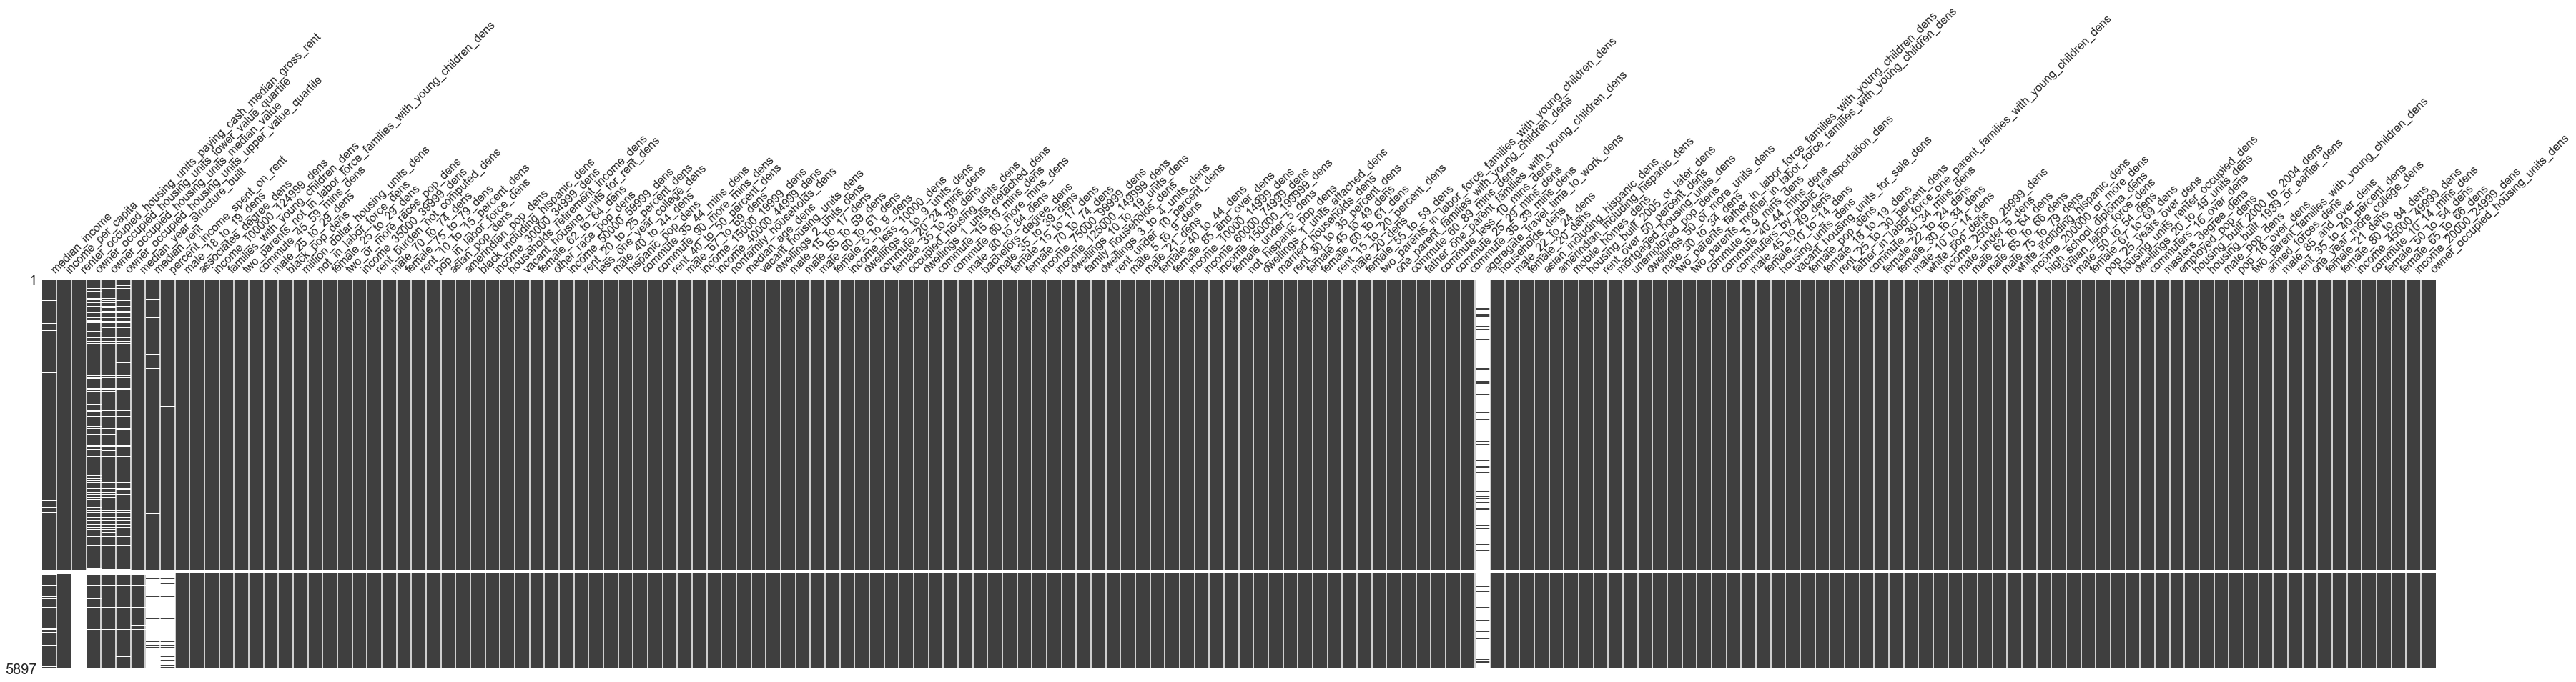

In [21]:
fig, ax = plt.subplots(figsize=(60,10),  nrows =1, ncols = 1)
msno.matrix(df_X[df_X_cols], labels = True, ax = ax) 

### Are the variables correlated?

Next, we will check the pair-wise correlations between the ACS variables. Correlated covariates are problematic for inference in linear (and generalized linear) models as they lead to inflation of the variance of the regression coefficient (https://en.wikipedia.org/wiki/Variance_inflation_factor) but do not necessarly represent a problem for prediction. However, if correlated variables are present, we can take advantage of these correlations to reduce the dimensionality of the model and save computation time.

Looking at the pair-wise correlations of a random sample of 50 variables, we notice large correlations.

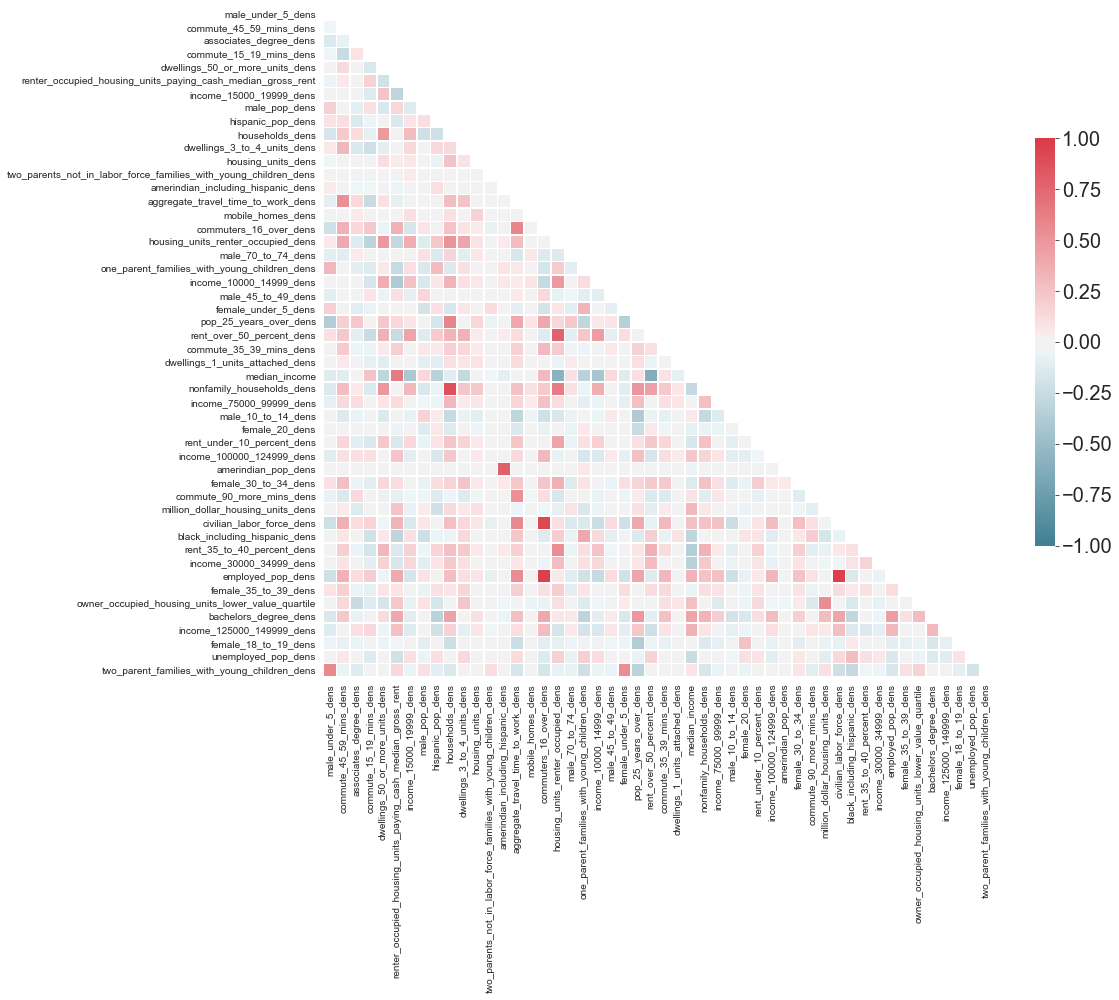

In [22]:
draw_corrm(df_X[random.sample(df_X_cols, 50)])

### To account for missing values and reduce the model dimensionality, we will transform the data using Priciple Component Analysis 

To impute the missing data and reduce the model dimensionality we will use a probabilistic formulation of Principal Component Analysis (PCA). PCA is a technique to transform data sets of high dimensional vectors into lower dimensional ones that finds a smaller-dimensional linear representation of data vectors such that the original data could be reconstructed from the compressed representation with the minimum square error.

In its probabilistic formulation, probabilistic PCA (PPCA) the complete data are modelled by a generative latent variable model which iteratively updates the expected complete data log-likelihood and the maximum likelihood estimates of the parameters. In PPCA, the data are incomplete because the principal components are not observed and are treated as latent variables, which also allows to extend the method to when missing data are present.

More information can be found at http://www.jmlr.org/papers/volume11/ilin10a/ilin10a.pdf.

#### PPCA in a nutshell

PCA can also be described as the maximum likelihood solution of a probabilistic latent variable
model, which is known as PPCA: 

\begin{equation*} Y_{ij} = \mathbf{P}_i \, \mathbf{Z}_j + m_i + \varepsilon_{ij} \quad i = 1, .., d; \, j = 1, .., n \end{equation*}


with

\begin{align}
p(\mathbf{Z}_j) \sim N(0,  \mathbb{1}) \\
p(\varepsilon_{ij}) \sim N(0,  \nu) 
\end{align}

Both the principal components $Z$ and the noise $\varepsilon$ are assumed normally distributed. The model can be identified by finding the maximum likelihood (ML) estimate for the model parameters using the Expectation-Maximization (EM) algorithm by minimizing the mean-square error of the observed part of the data. EM is a general framework for learning parameters with incomplete data which iteratively updates the expected complete data log-likelihood and the maximum likelihood estimates of the parameters. In PPCA, the data are incomplete because the principal components, $Z_i$, are not observed and are treated as latent variables. When missing data are present, in the E-step, the expectation of the complete-data log-likelihood is taken with respect to the conditional distribution of the latent variables given the observed variables. In this case, the update EM rules are the following.

1. E-step:
\begin{align}
\mathbf{\Sigma}_{\mathbf{Z}_j} =  \nu  \left(\nu \, \mathbb{1} + \sum_i  \mathbf{P}_i  \mathbf{P}_i^T \right)^{-1} \\
\overline{\mathbf{Z}}_j  = \dfrac{1}{\nu}\mathbf{\Sigma}_{\mathbf{Z}_j} \sum_i \mathbf{P}_i \left(Y_{ij}- m_i \right) \\
m_{i} = \dfrac{1}{n} \sum_j \left(Y_{ij} - \mathbf{P}_i^T \, \overline{\mathbf{Z}}_j \right) \\
\end{align}

1. M-step:
\begin{align}
\mathbf{P}_{i} = \left( \sum_j \overline{\mathbf{Z}}_j \overline{\mathbf{Z}}_j 
^T + \mathbf{\Sigma}_{\mathbf{Z}_j} \right)^{-1}  \sum_j \overline{\mathbf{Z}}_j \, \left(Y_{ij}- m_{ij} \right)\\
\nu = \dfrac{1}{n} \sum_{ij} \left[ \left(Y_{ij} - \mathbf{P}_i^T \, \overline{\mathbf{Z}}_j - m_i \right)^2 + \mathbf{P}_i^T \, \overline{\mathbf{Z}}_j \mathbf{P}_i \, \right]
\end{align}

where each row of $\mathbf{P}$ and $\overline{\mathbf{Z}}$ is recomputed based only on those columns of $\overline{\mathbf{Z}}$ which contribute to the reconstruction of the observed values in the corresponding row of the data matrix.

#### Impute missing values and extract PC scores (linearly decorrelated)

In [23]:
X, var_exp = run_ppca(df_X, df_X_cols, min_obs = 0.8)
X.head()

,geoid,median_income,income_per_capita,renter_occupied_housing_units_paying_cash_median_gross_rent,owner_occupied_housing_units_lower_value_quartile,owner_occupied_housing_units_median_value,owner_occupied_housing_units_upper_value_quartile,median_year_structure_built,median_rent,percent_income_spent_on_rent,...,pc_124,pc_125,pc_126,pc_127,pc_128,pc_129,pc_130,pc_131,pc_132,pc_133
0,360470340002,11341.0,12284.0,247.0,NaN,NaN,NaN,1994.0,181.0,29.2,...,0.052882,0.035244,-0.272179,0.540095,-0.499536,-0.166496,0.691058,-0.098954,-0.018632,0.042992
1,360471058042,12646.0,11530.0,322.0,NaN,NaN,NaN,1989.0,301.0,29.3,...,-1.904357,-0.149651,-0.506206,0.635975,0.621000,0.024523,-1.078909,-0.049090,-0.054530,0.537447
2,360810085002,NaN,11085.0,1631.0,NaN,NaN,NaN,1939.0,1620.0,50.0,...,0.128417,-0.208665,-1.130804,-0.263379,0.319421,-0.191368,0.272441,-0.642315,0.075760,0.099563
3,360811417005,45833.0,20522.0,1319.0,NaN,NaN,NaN,1969.0,1319.0,37.2,...,-0.117807,0.107891,0.448599,-0.142086,0.125943,-0.253386,-0.219790,-0.042805,0.242542,-0.248561
4,360470900001,41417.0,19454.0,1175.0,354000.0,483300.0,623100.0,1965.0,1175.0,50.0,...,0.102713,0.205192,0.258857,0.183891,0.318649,-0.259706,-0.200628,0.599910,-0.332049,0.094779


#### Plot explained variance

First, we compute the explained variance as a function of the number of PC scores retained to decide how many PCs we should keep. We decide to keep the PCs up that explain up to 80% of the variance (the black dashed line in the plot below), but this choice is somewhat arbitrary and might vary depending on the application. 

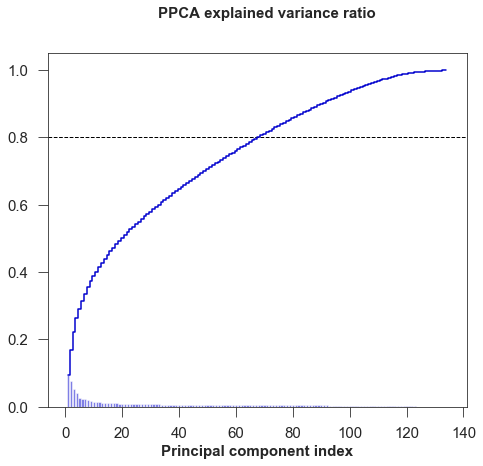

In [24]:
plot_pc_var(var_exp, textsize = 15, title = 'PPCA explained variance ratio')

#### Plot PC correlations

To understand the relashionship between the transformed variables (the PC scores) and the original variable, we can plot the 10 variables most highly correlated with each PC, as shown in the bar plot plot which shows the correlation for each of these variables. For example, we see that the first PC, which is that that explains the most of the variance, is positively correlated with the *density of ownner occupied housing units* but negatively correlated with the *density of renter occupied housing units*, as also the map below shows. 

*Note: depending on the random seed on your computer, the signs of the correlations might change.*

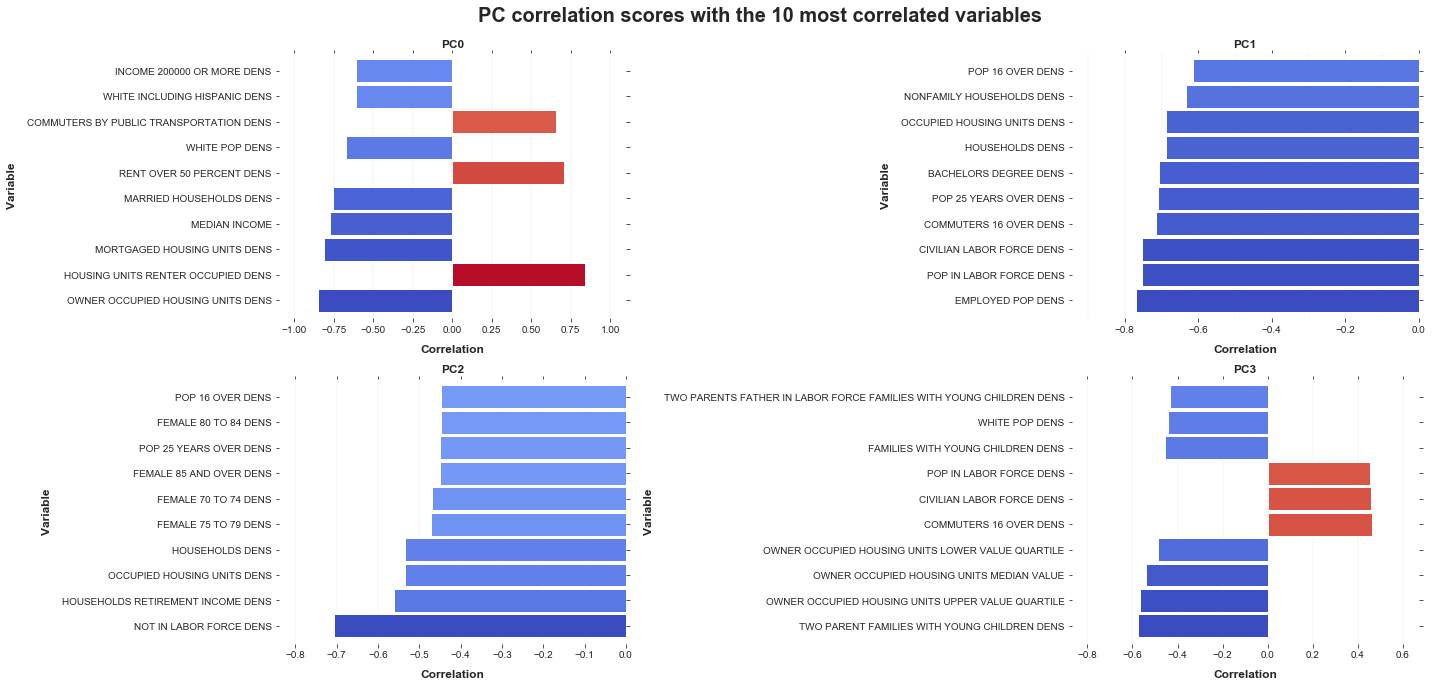

In [25]:
plot_pc_corr(X, df_X_cols)

#### Map the first Principal Component

In [48]:
map0 = Map(
    Layer(X,
          style = color_bins_style('pc_0',
                                palette = 'SunsetDark',
                                stroke_width = 1,
                                opacity = 0.5), 
          legends = color_bins_legend(title='First Principal Component Score (PC0)', 
                                      description='', 
                                   footer ='ACS'),
          popup_hover=[popup_element('pc_0', title='First Principal Component Score (PC0)')]
))


map1 = Map(
    Layer(X,
          style = color_bins_style('owner_occupied_housing_units_dens',
                                palette = 'SunsetDark',
                                stroke_width = 1,
                                opacity = 0.5), 
          legends = color_bins_legend(title='Density of Owner Occupied Housing Units', 
                                      description='', 
                                       footer ='ACS'),
          popup_hover=[popup_element('owner_occupied_housing_units_dens', title='Density of Owner Occupied Housing Units')]
))

map2 = Map(
    Layer(X,
          style = color_bins_style('housing_units_renter_occupied_dens',
                                palette = 'SunsetDark',
                                stroke_width = 1,
                                opacity = 0.5), 
          legends = color_bins_legend(title='Density of Renter Occupied Housing Units', 
                                      description='', 
                                   footer ='ACS'),
          popup_hover=[popup_element('housing_units_renter_occupied_dens', title='Density of Renter Occupied Housing Units')]
))

Layout([map0,map1,map2], 1,3,viewport={'zoom': 10, 'lat': 40.646891, 'lng': -73.869378})

ValueError: Wrong source. Valid sources are string, DataFrame or GeoDataFrame.

#### Select only up the PC up to expalain 80 % of the variance (dimensionality reduction)

In [27]:
cum_var_exp = np.cumsum(var_exp)
ncomponents = np.where(cum_var_exp > 0.8)[0][0]
X = X[['geoid','geometry'] + ['pc_' +  str(j) for j in range(ncomponents)]]

### Finally, Merge the ACS the store data and group the store revenue data by block group

In [28]:
stores_enriched = gpd.sjoin(stores[['revenue','the_geom']], X, how='right', op='intersects').drop('index_left', axis = 1)
stores_enriched.head()

,revenue,geoid,geometry,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,...,pc_57,pc_58,pc_59,pc_60,pc_61,pc_62,pc_63,pc_64,pc_65,pc_66
index_right,,,,,,,,,,,,,,,,,,,,,
2672,1.016898e+06,360810711002,"POLYGON ((-73.85603 40.72346, -73.85670 40.722...",0.179145,1.583147,2.023452,-2.631452,-0.860099,2.658238,-1.905773,...,-1.516299,-0.441122,0.192638,1.508883,-0.134574,0.233054,-0.011874,0.504401,0.368604,0.520358
2428,4.470646e+05,360810737002,"POLYGON ((-73.84536 40.71925, -73.84668 40.717...",0.374147,-6.119139,-1.134874,-4.018441,-0.641322,3.490450,-1.063123,...,1.735243,-0.070834,-0.190703,1.443695,-1.354218,0.102811,-0.658787,1.047303,0.521620,0.877140
3153,7.028071e+05,360810645002,"POLYGON ((-73.85714 40.71099, -73.85668 40.707...",1.008074,-1.683840,0.674212,-0.686784,-1.366442,1.381184,-0.612841,...,-0.899539,-0.368479,-1.255421,0.282796,-0.299881,-0.134622,0.272072,0.348535,-0.215908,-0.493371
3737,2.831908e+05,360810713053,"POLYGON ((-73.85288 40.72638, -73.85351 40.725...",3.741588,-7.828154,1.881884,-0.200184,0.972404,2.489148,-1.353116,...,-0.535270,-0.537460,-1.788984,0.561108,-1.502594,0.689878,0.961604,-0.438224,-0.634474,-0.272160
463,3.672994e+05,360810216001,"POLYGON ((-73.82640 40.71565, -73.82698 40.715...",2.008919,-4.253889,-3.343212,-0.823996,0.087085,2.732781,-1.477770,...,-0.621569,0.519670,-1.783965,0.886587,-0.561586,-0.254832,0.934688,0.466959,-0.236451,0.131301


## 5. Train the model using the data for the exisiting stores 

Having prepared the model covariates, then we will model the annual revenues by store ($\mathbf{y}$) using a Generalized Linear Model (GLM) with the selected PC scores as covariates ($\mathbf{X}$).

\begin{equation*} 
E\big[\mathbf{y}\vert\mathbf{X}\big] = g^{-1}\big(\sum_j \; X_j * beta_j \big)
\end{equation*}

where $E$ is the expectation value of the observations $\mathbf{y}$ conditional on the covariates $\mathbf{X}$ and $g$ is a link function. Given the distribution of the annual revenues, we will use a Gamma likelihood with a logarithmic link function.

In [29]:
df1 = stores_enriched[~np.isnan(stores_enriched['revenue'])]

In [30]:
lin_scale = 10**5
pc_cols = [i for i in df1.columns if 'pc_' in i]

y = df1['revenue'].values/lin_scale
X = df1[pc_cols]
X0 = np.ones((X.shape[0],1))
X = np.hstack((X,X0))

sm_fit = sm.GLM(y,X, family=sm.families.Gamma(link=sm.families.links.log)).fit()
df1['y_hat'] = sm_fit.predict(X)*lin_scale

Looking at the model results we notice a significant negative correlation with the first PC (which is lower in richer areas) and a significant positive correlation with the second and  third PCs which is negatively correlated with a higher workforce density and a higher density of female seniors.

*Note: the individual correlations with the PC and therefore with the original variables, might depend on the random seed on your computer but will be consistent overall.*

In [31]:
print(sm_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  177
Model:                            GLM   Df Residuals:                      109
Model Family:                   Gamma   Df Model:                           67
Link Function:                    log   Scale:                        0.028615
Method:                          IRLS   Log-Likelihood:                -333.47
Date:                Tue, 07 Jul 2020   Deviance:                       3.1425
Time:                        14:44:46   Pearson chi2:                     3.12
No. Iterations:                    17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1805      0.006    -30.802      0.0

To asses the model accuracy, we then plot the observed vs. the predicted values and compute the pseudo-$R^2$ score which is defined as 

\begin{equation*} 
1 - \dfrac{\sum_i (y_i - \hat{y}_i)^2}{\sum_i (y_i - \bar{y})^2}
\end{equation*}

As shown by the plot, below which indicates that most of the data points lie on the 1-1 line and a high value of the pseudo-$R^2$ score, we can conclude that our model is accurate in the in-sample predictions. 

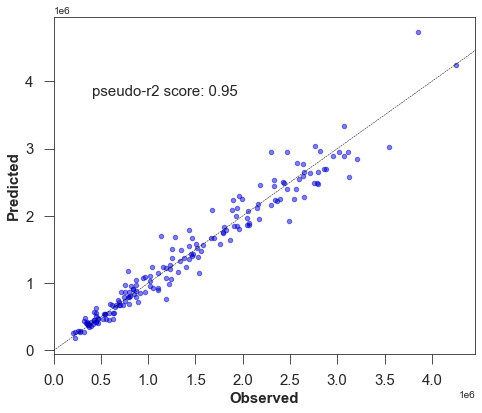

In [32]:
pandas_scatter(df1,'revenue','y_hat', xlab = 'Observed', ylab = 'Predicted', pseudo_R2 = True)

While GLM model typically do not overfit, we can also check the pseudo-$R^2$ score of the training and testing errors. 

In [33]:
X_train, X_test, y_train, y_test, idx_train, idx_test \
    = train_test_split(X, y, np.arange(X.shape[0]), test_size=0.2, random_state=42)

fitglm = sm.GLM(y_train,X_train, family=sm.families.Gamma(link=sm.families.links.log)).fit()
df1_train = df1.iloc[idx_train]
df1_test = df1.iloc[idx_test]

In [34]:
print('Training pseudo-r2 score: ' + str(pseudo_r2score(y_train,fitglm.predict(X_train))))

Training pseudo-r2 score: 0.95


In [35]:
print('Training pseudo-r2 score: ' + str(pseudo_r2score(y_test,fitglm.predict(X_test))))

Training pseudo-r2 score: 0.85


## 6. Get the predictions by Census block group

Finally, we can use this model to predict the annual revenue ($) for each block group in Long Island.

In [36]:
df2 = stores_enriched.copy()

In [37]:
y = df2['revenue'].values/lin_scale
X = df2[pc_cols]
X0 = np.ones((X.shape[0],1))
X = np.hstack((X,X0))

df2['revenue_pred'] = sm_fit.predict(X)*lin_scale

## 7. Visualize and share 

With CARTOframes you can then share your visualizations by publishing your map using a url.

### Upload data to CARTO

In [38]:
to_carto(df2,'starbucks_long_island_predictions', if_exists = 'replace')

Success! Data uploaded to table "starbucks_long_island_predictions" correctly


'starbucks_long_island_predictions'

### Visualize the predictions

In [39]:
bk = [i*10**5 for i in [4, 7, 10, 13, 16, 20, 30, 40]]
pubmap = Map(
    [Layer('starbucks_long_island_predictions',
          style = color_bins_style('revenue_pred',
                                breaks = bk,
                                palette = 'SunsetDark',
                                stroke_width = 1,
                                opacity = 0.5), 
          legends = color_bins_legend(title='Annual Predicted Revenue ($)', 
                                      description='', 
                                   footer =''),
          popup_hover=[popup_element('revenue_pred', title='Annual Predicted Revenue ($)')],
          widgets=[histogram_widget('revenue_pred',
                                    title='Annual Predicted Revenue ($)',
                                    description='Select a range of values to filter',
                                    buckets=15)]),
    Layer('starbucks_long_island_geocoded',
        style = size_bins_style('revenue', 
                                breaks = bk,
                                size_range = [1, 30],
                                color = '#00eaff',
                                stroke_color = '#006bff'),
          legends = size_bins_legend(title='Annual Revenue ($)',
                                   description='STARBUCKS', 
                                   footer ='2019'))
    ],show_info = True,
    viewport={'zoom': 9.4, 'lat': 40.673790, 'lng': -73.992685},
    size=(920,300)
)
pubmap

### Share your results

In [40]:
pubmap.publish("starbucks_long_island", 
               password=None,
               if_exists='replace')

The map has been published. The "cartoframes_12026fa313a1e0f2b864adbac15af74b" Maps API key with value "lqEbLeGgLBF9sHiwh0g2KQ" is being used for these datasets ['starbucks_long_island_geocoded', 'starbucks_long_island_predictions']. You can manage your API keys on your account.


{'id': '302fd3fc-2d3d-4b46-a659-7eadfabd042e',
 'url': 'https://team.carto.com/u/giulia-carto/kuviz/302fd3fc-2d3d-4b46-a659-7eadfabd042e',
 'name': 'starbucks_long_island',
 'privacy': 'public'}

## 5. Can we improve our model by accounting for any spatial dependence in the residuals?

Having assessed the performance of the non-spatial GLM model, we can check if the model residuals ${y_i-\hat{y_i}}$ show any residual spatial dependence, indicating that better results might be obtained using a model that explicitly takes the property that an observation is more correlated with an observation collected at a neighboring location than with another observation that is collected from farther away.

Including a spatially-structured random effects model that incorporates such spatial dependency is beneficial when the variables used as covariates in the model may not be sufficient to explain the variability of the observations and the measurements, given the predictors, are not independent. Including a spatially-structured random effect in the model helps mitigating the situation.

#### How to go spatial for spatially continuous processes?

A spatial stochastic process can be decomposed as:

\begin{equation*} y(\mathbf{s}) = \mu(\mathbf{s}) + w(\mathbf{s}) + \varepsilon \end{equation*}

where $\mu(\mathbf{s})$ is the mean function (deterministic and smooth), $\varepsilon$ is an independent process and 

\begin{equation*} w(\mathbf{s}) \sim GP\left(0, C(\mathbf{s}, \mathbf{s'},  \mathbf{\theta})\right) \end{equation*}

where the covariance $C(\mathbf{s}, \mathbf{s'},  \mathbf{\theta})$ typically depends on the Euclidean length of the spatial separation vector only $|\mathbf{h}| = |\mathbf{s} - \mathbf{s'}|$, and potentially on some hyperparameters $\mathbf{\theta}$. For example the exponential covariance function is defined as:

- Exponential covariance:

\begin{equation*} C \left(|\mathbf{h}|\right) = \sigma^2 exp(-\dfrac{1}{\rho} |\mathbf{h}|)  \end{equation*}

where the empirically derived definition for the range is $\rho = \dfrac{\sqrt{8 \nu}}{\kappa}$.

with the covariance between two points tending to zero as the points become further separated in space.

Fitting spatial models, comes with some caveats:

- Fitting the above model requires calculating determinants and inverses of large matrices: dense matrices scales cubically with matrix size, given by the number of locations where the process is observed
- Computational complexity grows with matrix size matrix complexity
- Memory limitations also create problems

#### Variograms

Variograms represent a useful tool to check for spatial dependence in the residuals. The variogram is defined as:

\begin{equation*} Var\left[y(\mathbf{s + h}) - y(\mathbf{s})\right]^2 =: 2\gamma(\mathbf{h}) = 2 \left(C \left(0\right) - C \left(|\mathbf{h}|\right)\right)\end{equation*}

First, we will construct an empirical variogram by grouping the pairs of observations in bins based on their distance (if isotropy is assumed) and averaging the squared differences from the values for all pairs. Given a semivariogram model, we can then fit this model to the empirical semivariogram and estimate the model parameters.

### First, fit a variogram model on the residuals

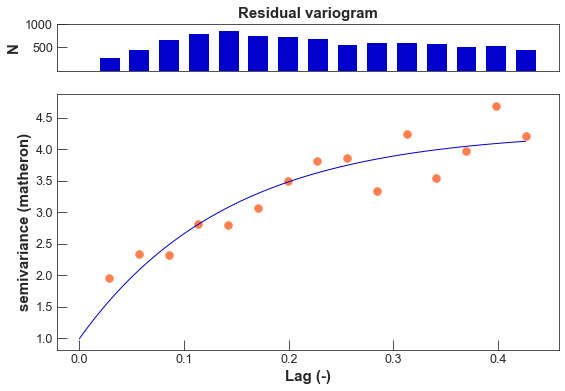

In [41]:
coords_x =  df1['geometry'].apply(lambda x: x.centroid.x)
coords_y = df1['geometry'].apply(lambda x: x.centroid.y)
coordinates = pd.concat([coords_x, coords_y], axis=1).values
values = (df1['y_hat']-df1['revenue'])/lin_scale

vg = Variogram(coordinates=coordinates, 
               values=values,
               normalize=False,
               use_nugget=True,
               model='exponential',
               maxlag="mean",
               n_lags=15)
ax = Variogram_plot(vg, fig_title='Residual variogram')

The variogram models parameters are:

In [42]:
print(vg)

exponential Variogram
---------------------
Estimator:         matheron
Effective Range:   0.43
Sill:              3.30
Nugget:            0.99
        


### Then, let's fit a Gaussian Process GLM model

We will now extend the GLM model to account for the residual spatial dependence, by fitting this model:

\begin{equation*} 
E\big[\mathbf{y}\vert\mathbf{X}\big] = g^{-1}\,\Big(\sum_j \; X_j * beta_j  + u(\mathbf{s}_i) + \varepsilon_i \Big)
\end{equation*}

where $u(\mathbf{s}_i)$ represents the spatially structured residuals modelled as a Gaussian Process with an exponential covariance function and $\varepsilon_i$ ad IID random term.

We will fit this model in a Bayesian framework using the programming language Stan (https://mc-stan.org). However, to reduce the model complexity we will fix the covariance parameters and use those derived from the variogram analysis (in a fully Bayesian approach these would be estimated).

The stan model is saved locally in _stan/GP_gamma_model_exact.stan_.

In [43]:
y = stores_enriched['revenue'].values/lin_scale
X = stores_enriched[pc_cols]
X0 = np.ones((X.shape[0],1))
X = np.hstack((X,X0))
coords_x = stores_enriched['geometry'].apply(lambda x: x.centroid.y)
coords_y = stores_enriched['geometry'].apply(lambda x: x.centroid.y)
coords = np.vstack((coords_x.values,coords_y.values)).T

y1 = y[~np.isnan(y)]
X1 = X[~np.isnan(y)]
coords1_x = df1['geometry'].apply(lambda x: x.centroid.y)
coords1_y = df1['geometry'].apply(lambda x: x.centroid.y)
coords1 = np.vstack((coords1_x.values,coords1_y.values)).T

pho, sigma, tau = vg.parameters

In [44]:
## Define the data dictionary the model
data = {'N': X1.shape[0],'K': X1.shape[1], 
        'X': X1, 'y': y1, 'coords':coords1, 
        'pho':pho, 'sigma':sigma, 'tau':tau}

## Compile the model
#stanm = pystan.StanModel(file='./stan/GP_gamma_model_exact.stan')

## Train the model and generate samples
#stan_fit = stanm.sampling(data=data, iter=1000, chains=3, 
#                          warmup=500, thin=1, seed=101)

## Save the model
#with gzip.open("./stan/GP_gamma_model_exact.gz", "wb") as f:
#    pickle.dump({'model' : stanm, 'fit' : stan_fit}, f, protocol=-1)

## Load the model
with gzip.open("./stan/GP_gamma_model_exact.gz", "rb") as f:
    data_dict = pickle.load(f)
stan_fit = data_dict['fit']

Extract the posterior mean and standard deviations

In [45]:
df1['y_hat_m'] = stan_fit.extract()['y_rep'].mean(axis=0)*lin_scale
df1['y_hat_se'] = stan_fit.extract()['y_rep'].std(axis=0)*lin_scale

(86054.29278814871, 7641334.01044289)

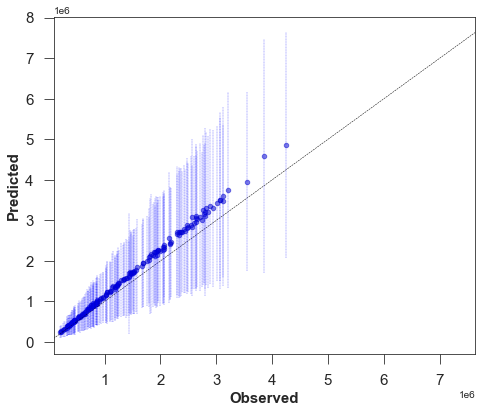

In [46]:
pandas_scatter(df1,'revenue','y_hat_m', xlab = 'Observed', ylab = 'Predicted', pseudo_R2 = False)
_ = plt.plot([df1.revenue,df1.revenue], 
             [df1['y_hat_m']-df1['y_hat_se'], df1['y_hat_m']+df1['y_hat_se']], 'b-', linewidth = 0.3,linestyle = '--') 
plt.xlim((df1['y_hat_m']-df1['y_hat_se']).min(),(df1['y_hat_m']+df1['y_hat_se']).max()) 

### Finally check that we have removed any residual spatial autocorrelation

We fit now the variogram mode to the model residuals, using the posterior mean.

Compared to the previous variogram plot, we can see that by adding a spatially structured random effect we have consistently reduced the spatial dependence in the residuals (check the scale of the y-axis).

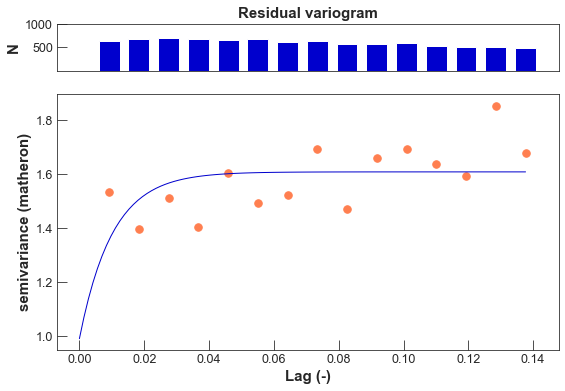

In [50]:
## Fit variogram model
values = (df1['y_hat_m']-df1['revenue'])/lin_scale
coordinates = coords1
vg = Variogram(coordinates=coordinates, 
               values=values,
               normalize=False,
               use_nugget=True,
               model='exponential',
               maxlag="mean",
               n_lags=15)
ax = Variogram_plot(vg, fig_title='Residual variogram')

### Next steps:

Clearly using the above model we have showed that we have removed the spatial dependence in the residuals. The next step would then be to use this model to make the predictions for the annual revenues for each census block group. However, because the computation time for GPs scales cubically with the data locations, we need some approximations which goes beyond the scope of this workshop. More information can be found here:

- Using Stan: https://arxiv.org/abs/2004.11408
- Using the Integrated Nested Laplace Approximation (INLA) with the stochastic partial differential equation approach (SPDE): http://www.r-inla.org, https://becarioprecario.bitbucket.io/spde-gitbook/, https://rss.onlinelibrary.wiley.com/doi/full/10.1111/j.1467-9868.2011.00777.x, 